In [1]:
from os import environ
# environ['OMP_NUM_THREADS'] = '1'
#environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax
import jax.numpy as jnp
import numpy as np
import diffrax
import sys
import argparse

from SALib.sample import morris as morris_sample

sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

sys.path.append("../")
from sampling_utils import *

sys.path.append("../gsa/")
from gsa_sample import *
from gsa_analyze import *

# tell jax to use 64bit floats
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

ModuleNotFoundError: No module named 'SALib'

In [2]:
# load data and model inputs
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')
inputs

array([0.001     , 0.0016788 , 0.00281838, 0.00473151, 0.00794328,
       0.01333521, 0.02238721, 0.03758374, 0.06309573, 0.10592537])

First we want to see what is happening with the Brightman and Fell model during the prior predictive checks by plotting a spaghetti plot of trajectories

In [3]:
BF_2000 = brightman_fell_2000(transient=True) # test with sustained EGF input first
p_dict, plist = BF_2000.get_nominal_params()
y0_dict, y0 = BF_2000.get_initial_conditions()
y0_tup = y0
# construct various initial conditions
inputs_native_units = (inputs*602214).round().astype(int)
state_names = list(y0_dict.keys())
EGF_idx = state_names.index('L')
RS_idx = state_names.index('Rs')
y0 = np.array([y0])
# y0[0][0] = 7500
y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, y0, EGF_idx)
ERK_indices = [state_names.index(s) for s in 'ERKPP'.split(',')]

# load the prior predictive samples
# prior_samples_idata = az.from_json("../../../results/MAPK/param_est/brightman_fell_2000_prior_predictive_idata.json")
# prior_samples_act_percents = np.load("../../../results/MAPK/param_est/brightman_fell_2000_prior_predictive_samples.npy")

prior_samples_idata = az.from_json("../../../results/MAPK/param_est/test_BF_transient/tr_brightman_fell_2000_prior_predictive_idata.json")
prior_samples_act_percents = np.load("../../../results/MAPK/param_est/test_BF_transient/tr_brightman_fell_2000_prior_predictive_samples.npy")

tmax = 1000
times = np.linspace(0, tmax, 300)

In [4]:
prior_samples_idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [5]:
# construct matrix of param samples
n_samples = prior_samples_idata['prior'].dims['draw']
free_param_list = list(prior_samples_idata['prior'].data_vars.keys())
param_sets = []
param_names = list(p_dict.keys())

idxs = np.arange(0, n_samples)
np.random.shuffle(idxs)

for i in idxs:
    p_set =[]
    for param in param_names:
        if param in free_param_list:
            p_set.append(prior_samples_idata['prior'].sel(draw=i)[param].to_numpy()[0])
        else:
            p_set.append(prior_samples_idata['constant_data'].data_vars[param].to_numpy()[0])
    param_sets.append(p_set)
param_sets = jnp.array(param_sets)

In [15]:
param_sets = param_sets.at[:,list(p_dict.keys()).index('E')].set(1.0) #set(p_dict['E'])
param_sets = param_sets.at[:,list(p_dict.keys()).index('f')].set(p_dict['f'])
param_sets = param_sets.at[:,list(p_dict.keys()).index('DT')].set(p_dict['DT'])

Run the vmapped solver

In [7]:
@jax.jit
def solve_traj(model_dfrx_ode, y0, params, t1, times, ERK_indices):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values.
    Returns an array of shape (n_species, 1) """
    dt0=1e-3
    solver = diffrax.Kvaerno5()
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        model_dfrx_ode, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat,
        stepsize_controller=stepsize_controller,
        args=tuple(list(params)),
        max_steps=600000,
        throw=False,)

    # return sum over the active ERK states (total ERK activation)
    # return jnp.sum(jnp.array(sol.ys)[ERK_indices, :], axis=0)
    return jnp.array(sol.ys)

    
vsolve_traj = jax.vmap(solve_traj, in_axes=(None, None, 0, None, None, None))

In [16]:
trajs = [vsolve_traj(diffrax.ODETerm(BF_2000), tuple(ic.tolist()), param_sets[:10,:], tmax, times, ERK_indices) for ic in y0_EGF_ins]
y0 = list(y0_tup)
y0[2] = 100
y0_yup = tuple(y0)
traj_nominal = solve_traj(diffrax.ODETerm(BF_2000), y0_tup, plist, tmax, times, ERK_indices)

negative value, param set0
negative value, param set1
negative value, param set2
negative value, param set3
negative value, param set4
negative value, param set5
negative value, param set6
negative value, param set7
negative value, param set8
negative value, param set9
negative value, param set0
negative value, param set1
negative value, param set2
negative value, param set3
negative value, param set4
negative value, param set5
negative value, param set6
negative value, param set7
negative value, param set8
negative value, param set9
negative value, param set0
negative value, param set1
negative value, param set2
negative value, param set3
negative value, param set4
negative value, param set5
negative value, param set6
negative value, param set7
negative value, param set8
negative value, param set9
negative value, param set0
negative value, param set1
negative value, param set2
negative value, param set3
negative value, param set4
negative value, param set5
negative value, param set6
n

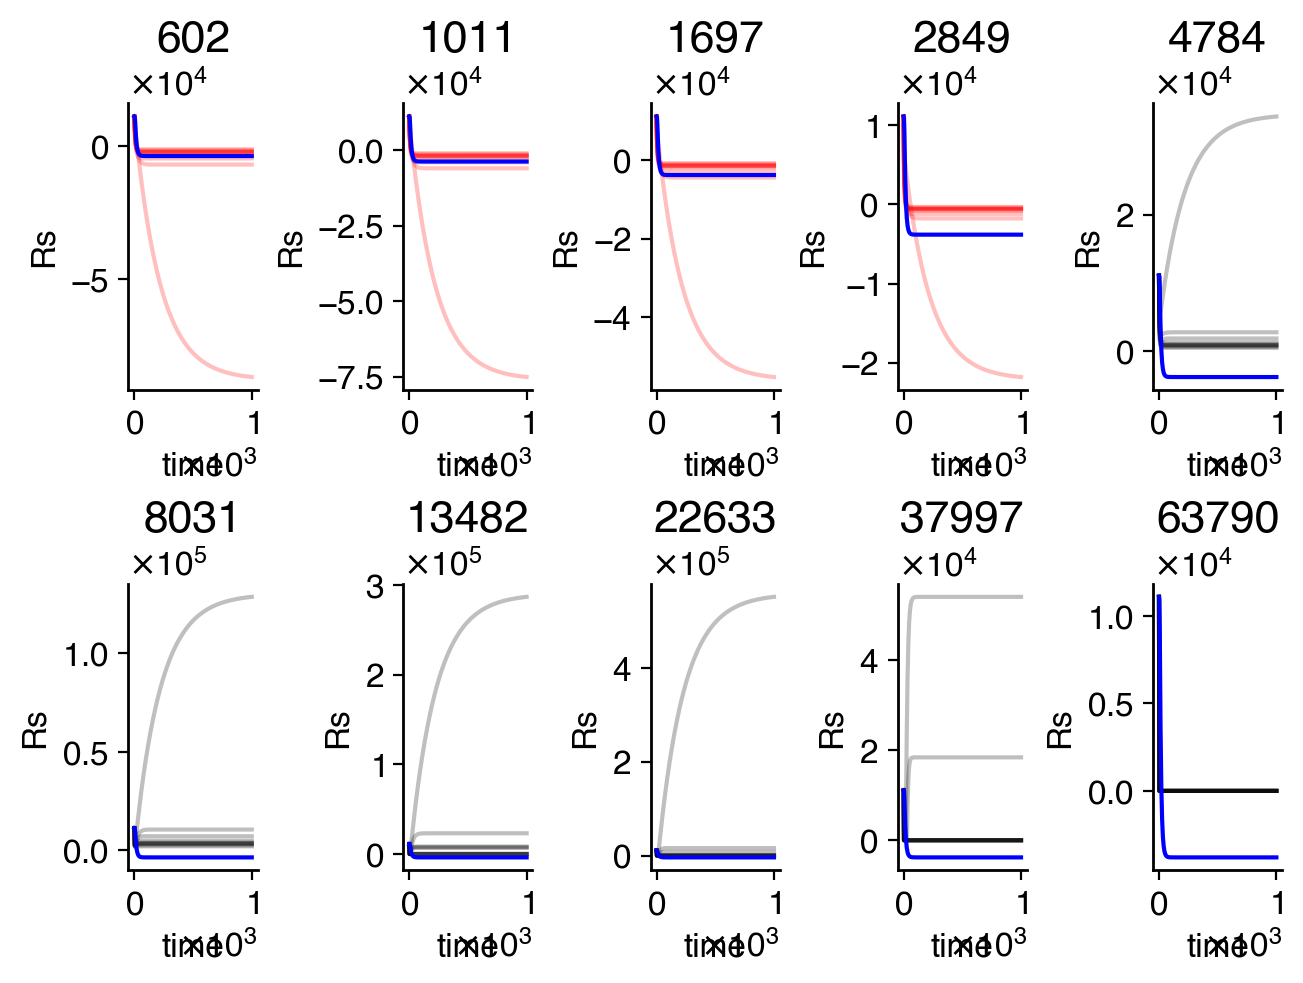

In [17]:
fig, ax = plt.subplots(2,5,layout='constrained',)
counter = 0
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for i in range(trajs[counter].shape[0]):
            if np.any(trajs[counter][i,0,:] < -100):
                color = 'r'
                print('negative value, param set{}'.format(i))
            else:
                color = 'k'
            col.plot(times, trajs[counter][i,0,:], c=color, alpha=0.25)
        col.plot(times, traj_nominal[0,:], c='b')
        col.set_xlabel('time')
        col.set_ylabel('Rs')
        col.set_title(inputs_native_units[counter])
        counter += 1

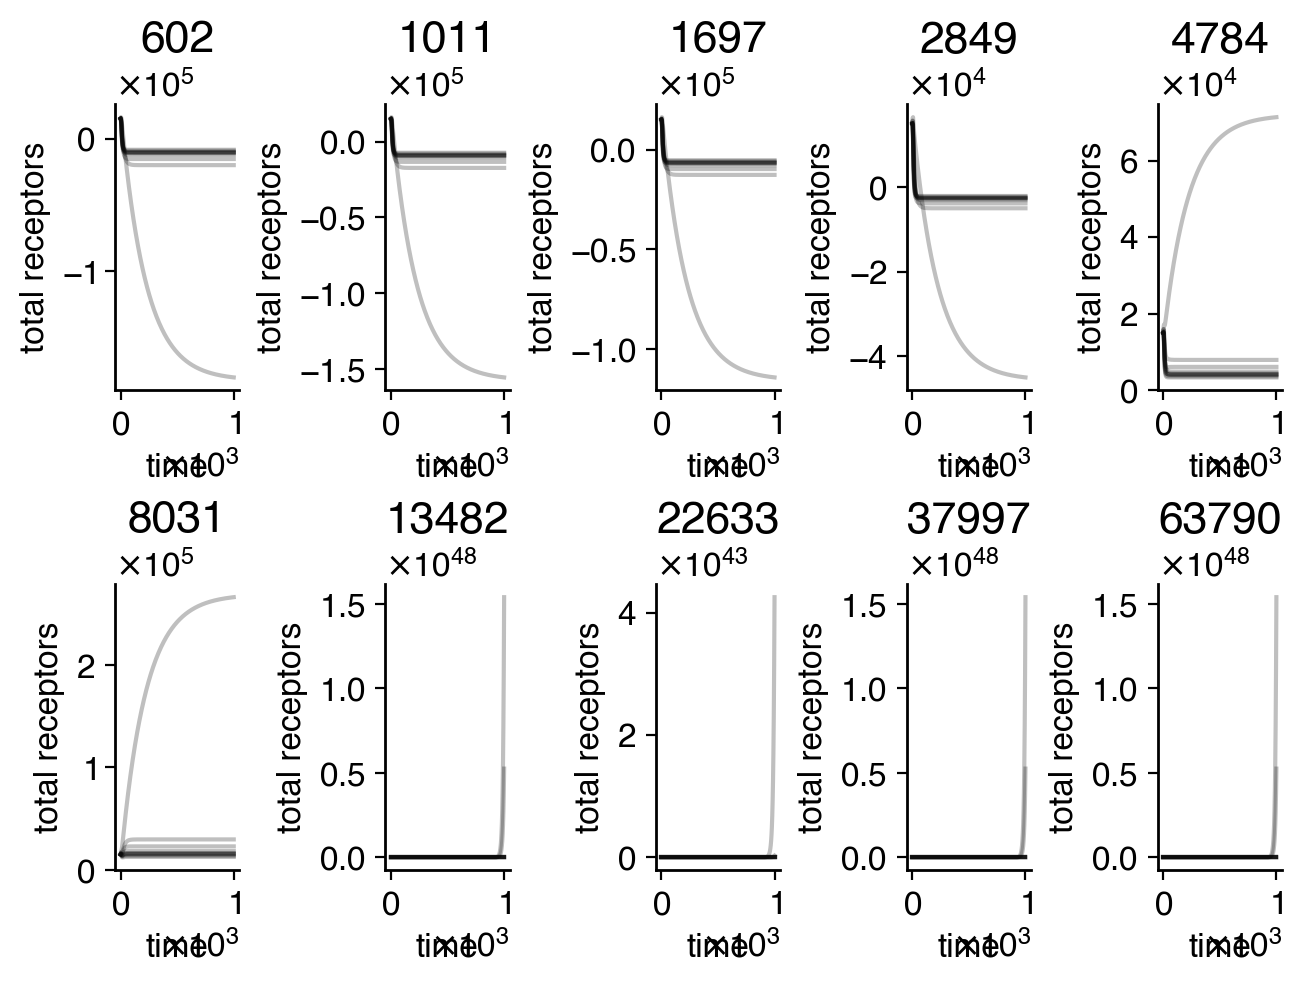

In [10]:

fig, ax = plt.subplots(2,5,layout='constrained',)
counter = 0
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for i in range(trajs[counter].shape[0]):
            col.plot(times, (trajs[counter][i,0,:]+trajs[counter][i,1,:]+
                             trajs[counter][i,2,:]+trajs[counter][i,4,:]+trajs[counter][i,5,:]+trajs[counter][i,7,:]), c='k', alpha=0.25)
        col.set_xlabel('time')
        col.set_ylabel('total receptors')
        col.set_title(inputs_native_units[counter])
        counter += 1

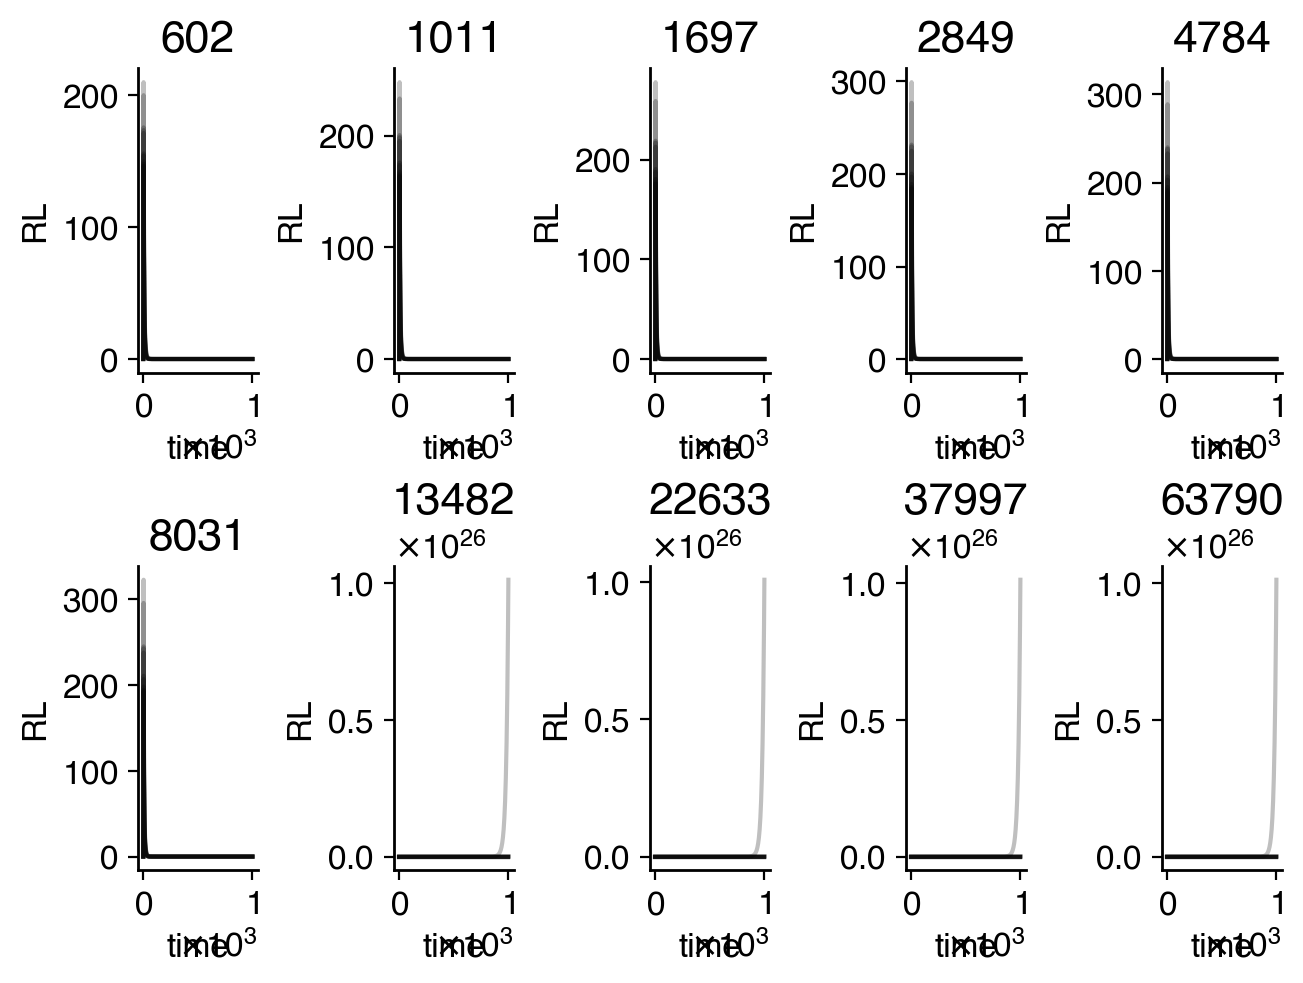

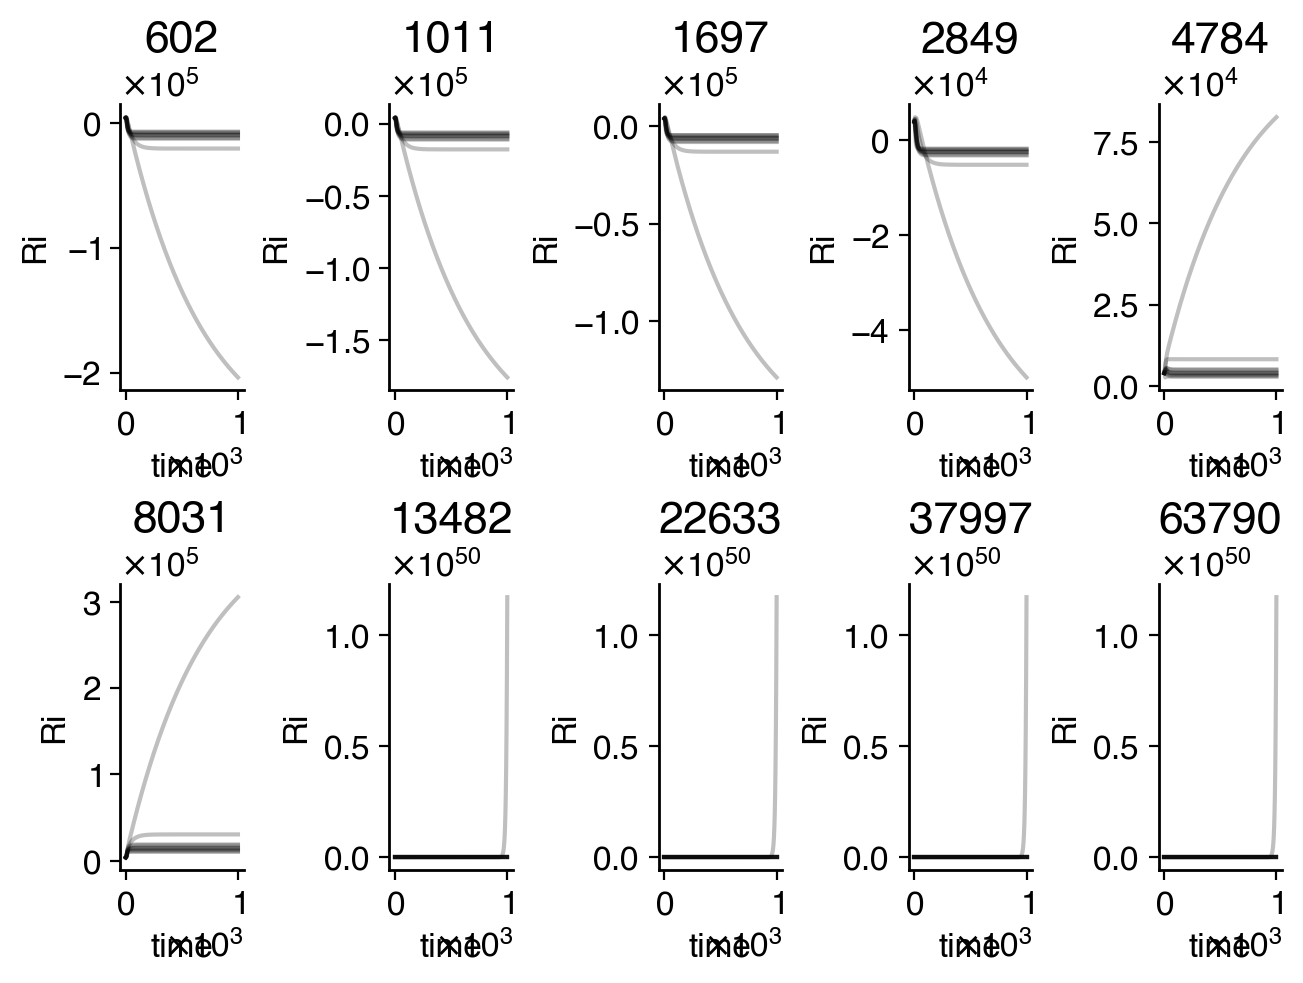

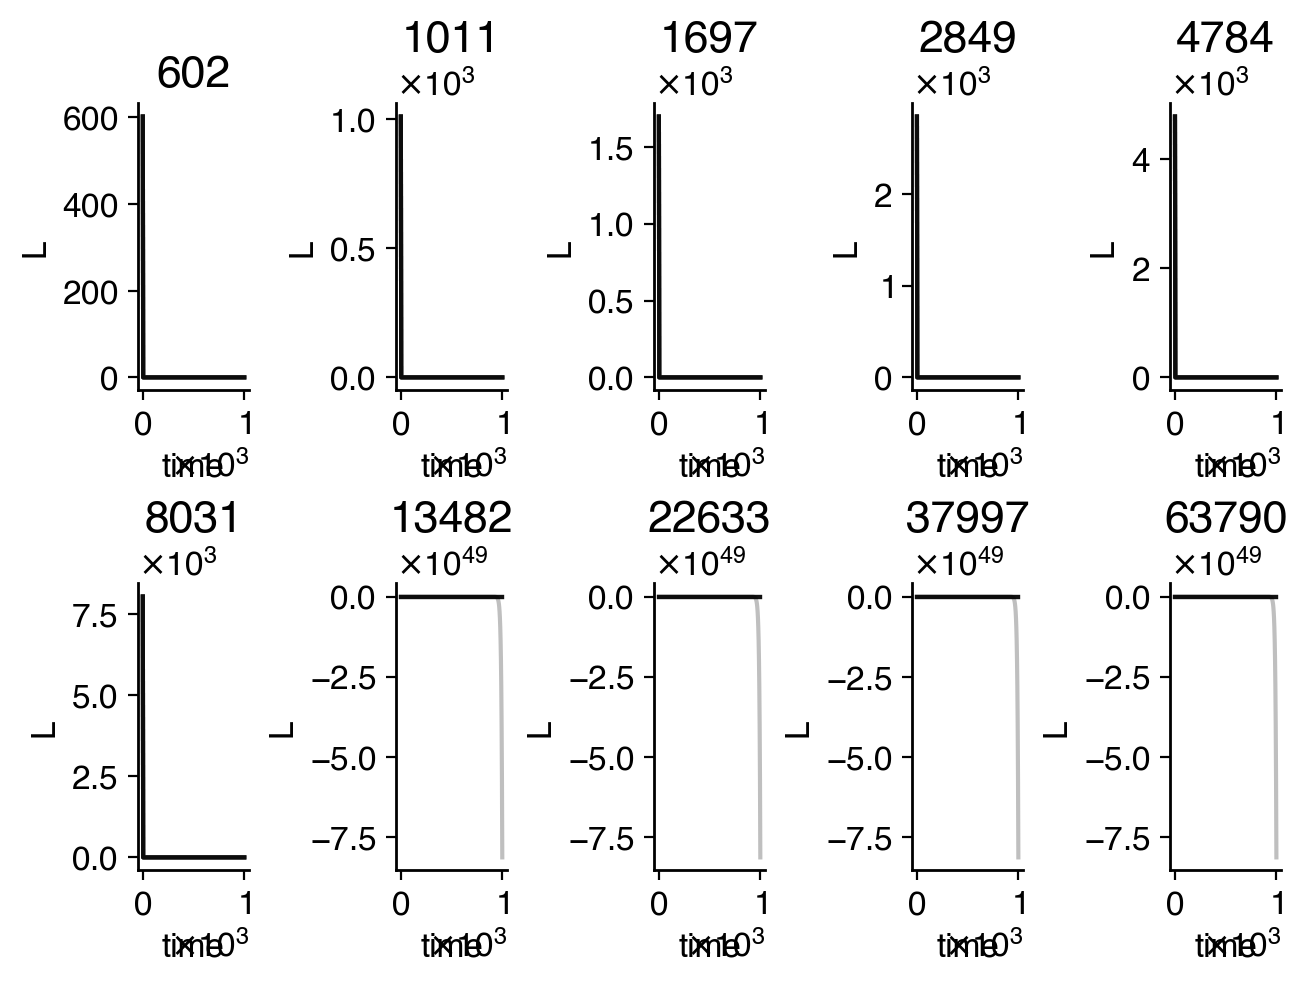

In [82]:
fig, ax = plt.subplots(2,5,layout='constrained',)
counter = 0
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for i in range(trajs[counter].shape[0]):
            col.plot(times, trajs[counter][i,1,:], c='k', alpha=0.25)
        col.set_xlabel('time')
        col.set_ylabel('RL')
        col.set_title(inputs_native_units[counter])
        counter += 1

fig, ax = plt.subplots(2,5,layout='constrained',)
counter = 0
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for i in range(trajs[counter].shape[0]):
            col.plot(times, trajs[counter][i,2,:], c='k', alpha=0.25)
        col.set_xlabel('time')
        col.set_ylabel('Ri')
        col.set_title(inputs_native_units[counter])
        counter += 1

fig, ax = plt.subplots(2,5,layout='constrained',)
counter = 0
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for i in range(trajs[counter].shape[0]):
            col.plot(times, trajs[counter][i,3,:], c='k', alpha=0.25)
        col.set_xlabel('time')
        col.set_ylabel('L')
        col.set_title(inputs_native_units[counter])
        counter += 1

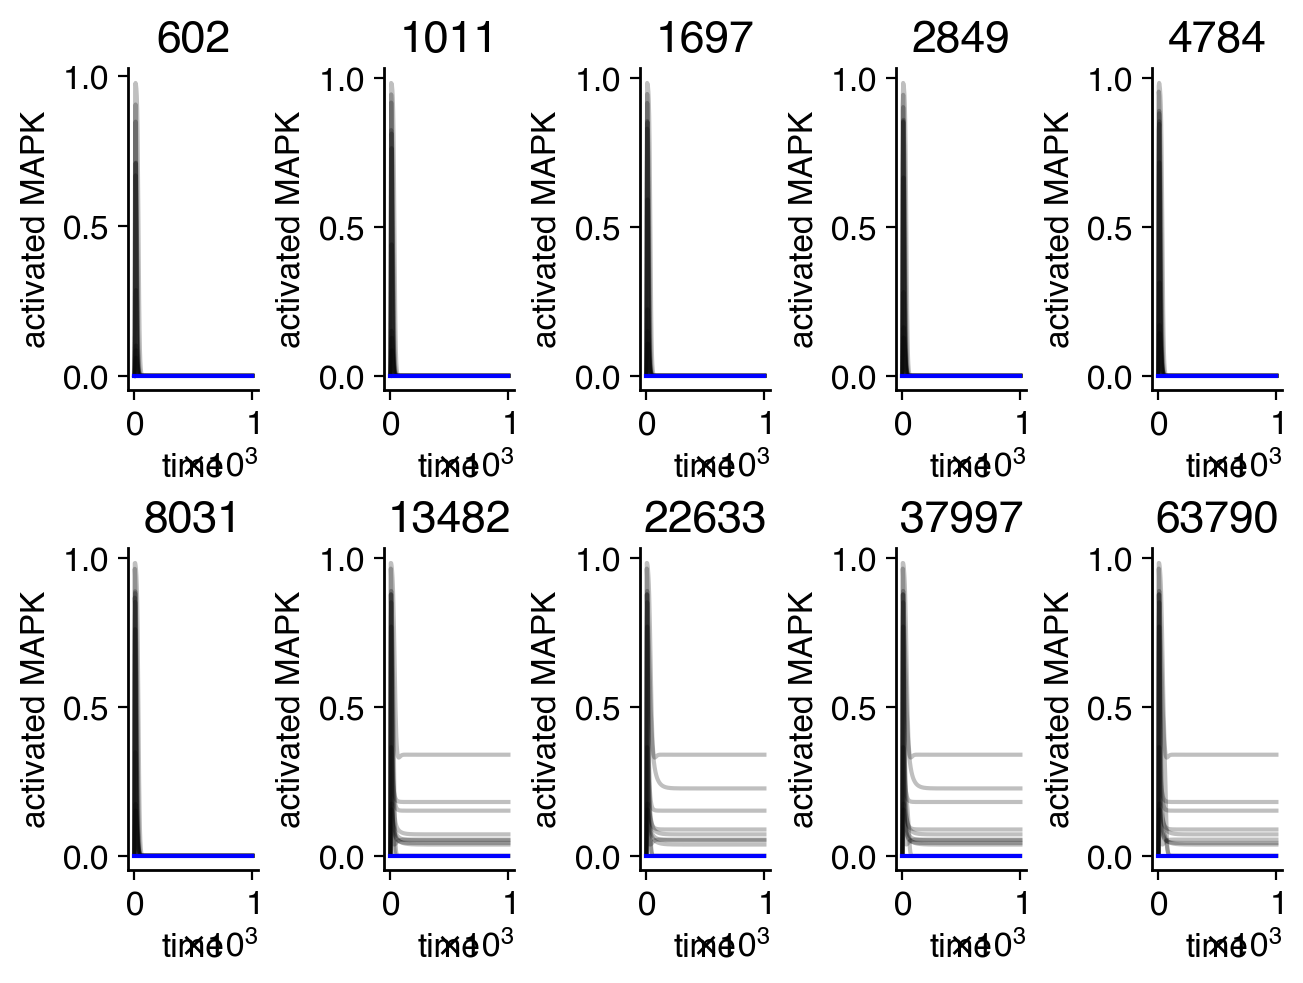

In [14]:
fig, ax = plt.subplots(2,5,layout='constrained',)
counter = 0
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for i in range(trajs[counter].shape[0]):
            col.plot(times, trajs[counter][i,ERK_indices[0],:]/y0_dict['ERK'], c='k', alpha=0.25)
        col.plot(times, traj_nominal[ERK_indices[0],:]/y0_dict['ERK'], c='b')
        col.set_xlabel('time')
        col.set_ylabel('activated MAPK')
        col.set_title(inputs_native_units[counter])
        counter += 1

### Repeat for Shin 2014 model

In [186]:
S_2014 = shin_2014(transient=False) # test with sustained EGF input first
p_dict, plist = S_2014.get_nominal_params()
y0_dict, y0 = S_2014.get_initial_conditions()

# construct various initial conditions
inputs_native_units = inputs*1e-3
state_names = list(y0_dict.keys())
EGF_idx = state_names.index('EGF')
y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)
ERK_indices = [state_names.index(s) for s in 'pp_ERK'.split(',')]

no_EGF = np.copy(y0_EGF_ins[2])
no_EGF[EGF_idx] = 0

# load the prior predictive samples
prior_samples_idata = az.from_json("../../../results/MAPK/param_est/wider_prior/shin_2014_prior_predictive_idata.json")
prior_samples_act_percents = np.load("../../../results/MAPK/param_est/wider_prior/shin_2014_prior_predictive_samples.npy")

times = np.linspace(0, 300, 1000)

In [187]:
# construct matrix of param samples
n_samples = prior_samples_idata['prior'].dims['draw']
free_param_list = list(prior_samples_idata['prior'].data_vars.keys())
param_sets = []
param_names = list(p_dict.keys())

for i in range(n_samples):
    p_set =[]
    for param in param_names:
        if param in free_param_list:
            p_set.append(prior_samples_idata['prior'].sel(draw=i)[param].to_numpy()[0])
        else:
            p_set.append(prior_samples_idata['constant_data'].data_vars[param].to_numpy()[0])
    param_sets.append(p_set)
param_sets = jnp.array(param_sets)

In [191]:
traj_low_EGF = vsolve_traj(diffrax.ODETerm(S_2014), tuple(y0_EGF_ins[0].tolist()), param_sets[:60,:], 1000, times, ERK_indices)
traj_medium_EGF = vsolve_traj(diffrax.ODETerm(S_2014), tuple(y0_EGF_ins[6].tolist()), param_sets[:60,:], 1000, times, ERK_indices)
traj_high_EGF = vsolve_traj(diffrax.ODETerm(S_2014), tuple(y0_EGF_ins[9].tolist()), param_sets[:60,:], 1000, times, ERK_indices)

Text(0, 0.5, 'activated MAPK')

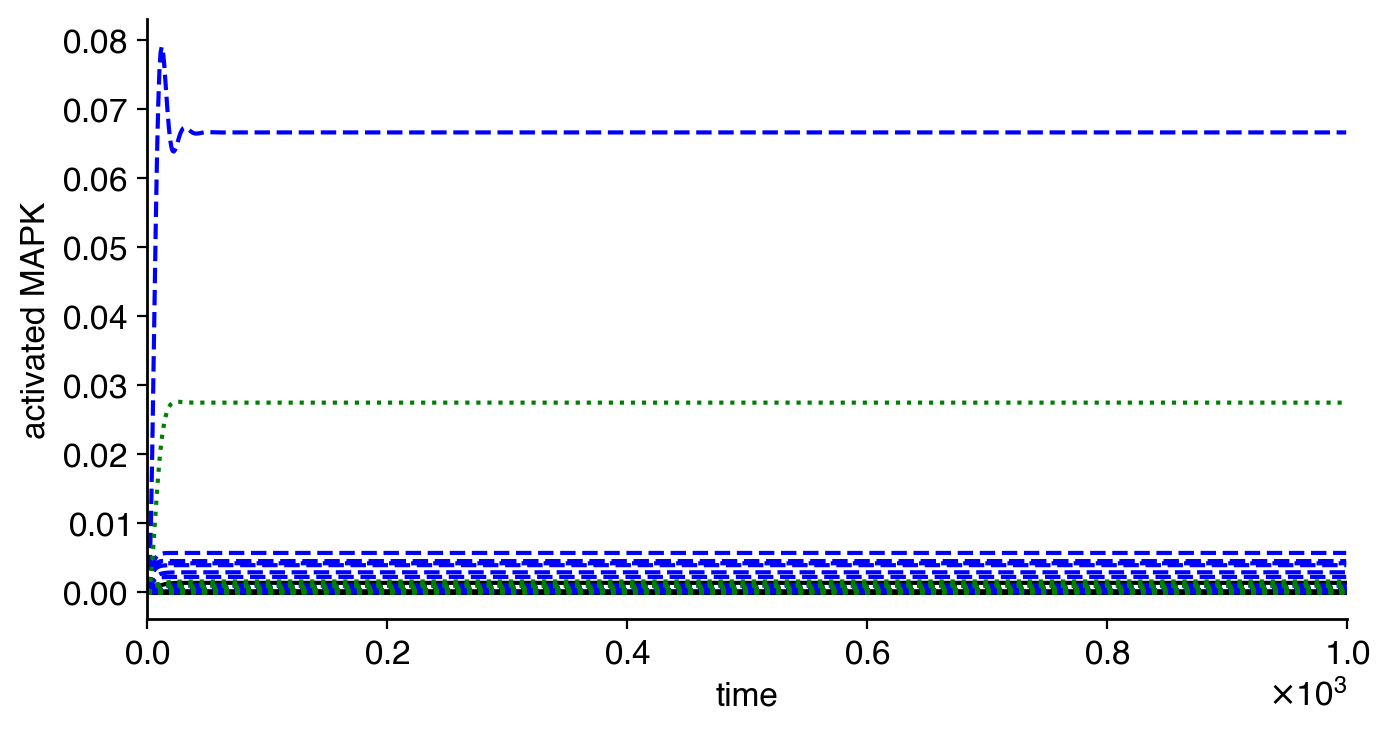

In [192]:
fig, ax = plt_func.get_sized_fig_ax(6.0,3.0)

for i in range(traj_low_EGF.shape[0]):
    ax.plot(traj_low_EGF[i,:], c='k')

for i in range(traj_high_EGF.shape[0]):
    ax.plot(traj_high_EGF[i,:], c='b', linestyle='--')

for i in range(traj_medium_EGF.shape[0]):
    ax.plot(traj_medium_EGF[i,:], c='g', linestyle=':')

ax.set_xlim(0, 1000)
ax.set_xlabel('time')
ax.set_ylabel('activated MAPK')

### And for the Hornberg 2005 model

In [23]:
H_2005 = hornberg_2005(transient=True) # test with sustained EGF input first
p_dict, plist = H_2005.get_nominal_params()
y0_dict, y0 = H_2005.get_initial_conditions()

# construct various initial conditions
inputs_native_units = inputs*602214
state_names = list(y0_dict.keys())
EGF_idx = state_names.index('c1')
y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)
ERK_indices = [state_names.index(s) for s in 'c59,c83'.split(',')]

# load the prior predictive samples
prior_samples_idata = az.from_json("../../../results/MAPK/param_est/hornberg_2005_prior_predictive_idata.json")
prior_samples_act_percents = np.load("../../../results/MAPK/param_est/hornberg_2005_prior_predictive_samples.npy")

times = np.linspace(0, 6000, 6000)

# construct matrix of param samples
n_samples = prior_samples_idata['prior'].dims['draw']
free_param_list = list(prior_samples_idata['prior'].data_vars.keys())
param_sets = []
param_names = list(p_dict.keys())

for i in range(n_samples):
    p_set =[]
    for param in param_names:
        if param in free_param_list:
            p_set.append(prior_samples_idata['prior'].sel(draw=i)[param].to_numpy()[0])
        else:
            p_set.append(prior_samples_idata['constant_data'].data_vars[param].to_numpy()[0])
    param_sets.append(p_set)
param_sets = jnp.array(param_sets)

In [28]:
ERK_indices

[58, 82]

In [29]:
traj_low_EGF = vsolve_traj(diffrax.ODETerm(H_2005), tuple(y0_EGF_ins[0].tolist()), param_sets[15:25,:], 6000, times, ERK_indices)
traj_medium_EGF = vsolve_traj(diffrax.ODETerm(H_2005), tuple(y0_EGF_ins[6].tolist()), param_sets[15:25,:], 6000, times, ERK_indices)
traj_high_EGF = vsolve_traj(diffrax.ODETerm(H_2005), tuple(y0_EGF_ins[9].tolist()), param_sets[15:25,:], 6000, times, ERK_indices)

KeyboardInterrupt: 

Text(0, 0.5, 'activated MAPK')

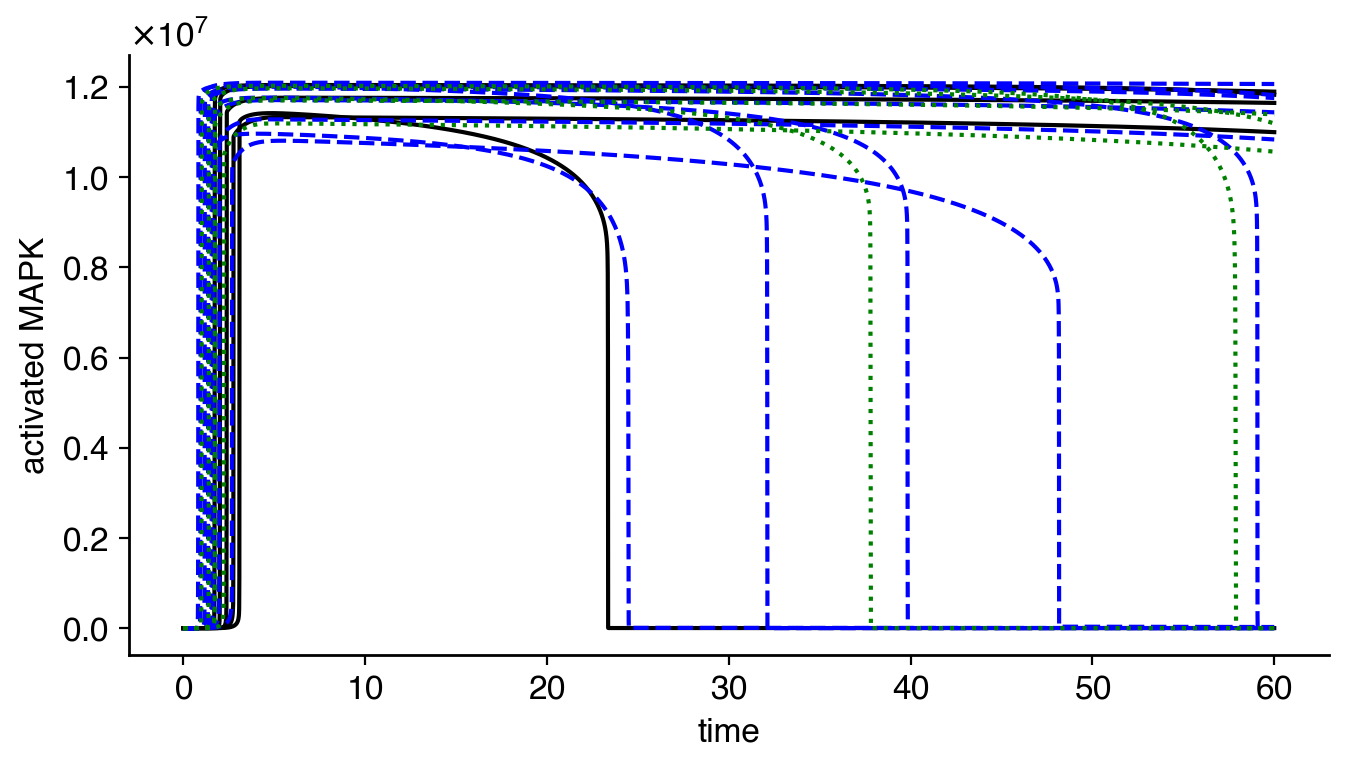

In [ ]:
fig, ax = plt_func.get_sized_fig_ax(6.0,3.0)

for i in range(traj_low_EGF.shape[0]):
    ax.plot(times/100, traj_low_EGF[i,:], c='k')

for i in range(traj_high_EGF.shape[0]):
    ax.plot(times/100,traj_high_EGF[i,:], c='b', linestyle='--')

for i in range(traj_medium_EGF.shape[0]):
    ax.plot(times/100,traj_medium_EGF[i,:], c='g', linestyle=':')

# ax.set_xlim(0, 6000)
ax.set_xlabel('time')
ax.set_ylabel('activated MAPK')

## Orton 2009

In [133]:
O_2009 =orton_2009(transient=False) # test with sustained EGF input first
p_dict, plist = O_2009.get_nominal_params()
y0_dict, y0 = O_2009.get_initial_conditions()

# construct various initial conditions
inputs_native_units = inputs*602214
state_names = list(y0_dict.keys())
EGF_idx = state_names.index('EGF')
y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)
ERK_indices = [state_names.index(s) for s in 'MAPK_PP'.split(',')]

no_EGF = np.copy(y0_EGF_ins[2])
no_EGF[EGF_idx] = 0

# load the prior predictive samples
prior_samples_idata = az.from_json("../../../results/MAPK/param_est/orton_2009_prior_predictive_idata.json")
prior_samples_act_percents = np.load("../../../results/MAPK/param_est/orton_2009_prior_predictive_samples.npy")

times = np.linspace(0, 10000, 1000)

In [134]:
# construct matrix of param samples
n_samples = prior_samples_idata['prior'].dims['draw']
free_param_list = list(prior_samples_idata['prior'].data_vars.keys())
param_sets = []
param_names = list(p_dict.keys())

for i in range(n_samples):
    p_set =[]
    for param in param_names:
        if param in free_param_list:
            p_set.append(prior_samples_idata['prior'].sel(draw=i)[param].to_numpy()[0])
        else:
            p_set.append(prior_samples_idata['constant_data'].data_vars[param].to_numpy()[0])
    param_sets.append(p_set)
param_sets = jnp.array(param_sets)

In [135]:
traj_low_EGF = vsolve_traj(diffrax.ODETerm(K_2000), tuple(y0_EGF_ins[0].tolist()), param_sets[0:500,:], times[-1], times, ERK_indices)
traj_medium_EGF = vsolve_traj(diffrax.ODETerm(K_2000), tuple(y0_EGF_ins[6].tolist()), param_sets[0:500,:], times[-1], times, ERK_indices)
traj_high_EGF = vsolve_traj(diffrax.ODETerm(K_2000), tuple(y0_EGF_ins[9].tolist()), param_sets[0:500,:], times[-1], times, ERK_indices)

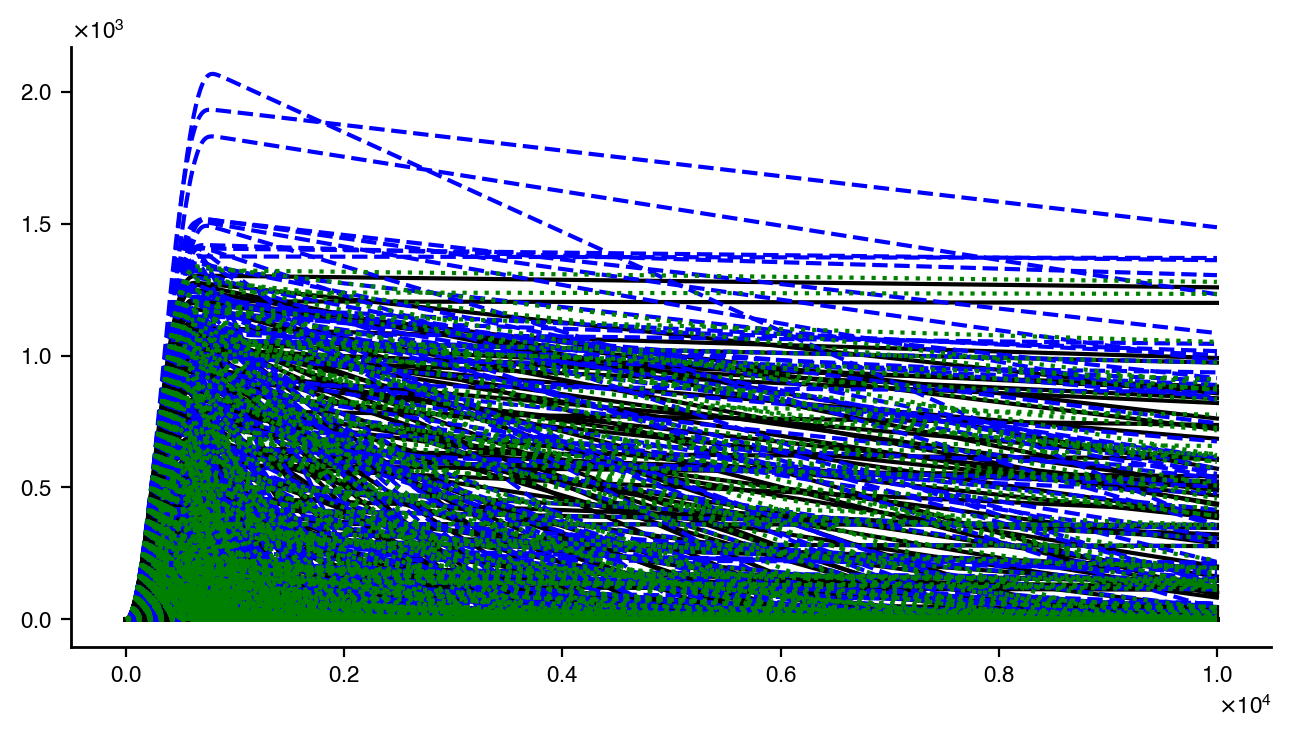

In [136]:
fig, ax = plt_func.get_sized_fig_ax(6.0,3.0)

for i in range(traj_low_EGF.shape[0]):
    ax.plot(times, traj_low_EGF[i,:], c='k')

for i in range(traj_high_EGF.shape[0]):
    ax.plot(times, traj_high_EGF[i,:], c='b', linestyle='--')

for i in range(traj_medium_EGF.shape[0]):
    ax.plot(times, traj_medium_EGF[i,:], c='g', linestyle=':')

In [35]:
ERK_indices

[15]